# Logistic Regression and SGD Homework 
***
**Name**: Prashil Bhimani
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [2]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [3]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

1. The length of vocabulary list is 5327. But as the 1st element is the bias term the number of actual words is 5326.
2. The features are generated by bag of words model. We are incrementing the count for the word everytime we encounter the word and it matches with a word in vocabulary.
3. The positive raw file has documents related to motorcycles and the negative raw files has domunents related to automobiles. Hence 0 refers to automobiles and 1 refers to motorcycles

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [4]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        if iteration==0:
            for i in range(1,len(self.w)):
                self.last_update[i]=1
        muii= self.sigmoid(self.w.dot(train_example.x))-train_example.y
        self.w[0]=self.w[0]-self.eta * muii
        for k in range(1,len(self.w)):
            self.w[k]=self.w[k]-self.eta * (train_example.x[k] * muii)
        for k in range(1,len(self.w)):
            if k in train_example.nonzero.keys():
                self.w[k]=self.w[k]*math.pow((1-2*self.lam*self.eta),self.last_update[k])
                self.last_update[k]=1
            else:
                self.last_update[k]=self.last_update[k]+1
        
        # TODO implement LSR updates of weights 
        

In [5]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(report_step=20)

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [6]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.014s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [7]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

Lets first find the most optimal epoch to avoid overfitting:


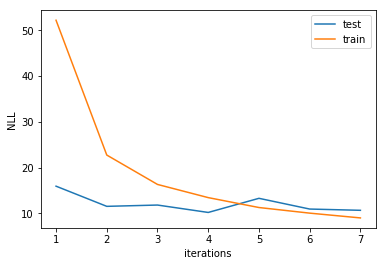

In [8]:
test_nll=[]
train_nll=[]
for e in range(1,8):
    lr = LogReg(train_set, test_set, lam=0, eta=0.1)
    lr.train(num_epochs=e,report_step=5)
    test_nll.append(lr.test_nll[-1])
    train_nll.append(lr.train_nll[-1])
plt.plot(range(1,8),test_nll)
plt.plot(range(1,8),train_nll)
plt.xlabel("iterations")
plt.ylabel("NLL")
plt.legend(["test","train"])

So as we can see that the number of nll of test increases after 5th epoch we can say that if we have more than 5 epochs than the data will be over fitted. We will run alogirthm currently on num_epochs=1 as it was taking a lot of time to run it on 5 epochs. To have less cluttered graph we will report steps after 50 iterations

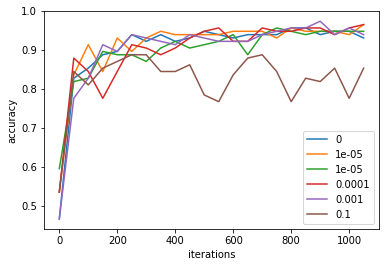

In [9]:
k=[0,0.00001,0.00001,0.0001,0.001,0.1]
for i in k:
    lr = LogReg(train_set, test_set, lam=i, eta=0.1)
    lr.train(num_epochs=1,report_step=50)
    l=range(0,len(lr.test_acc)*50,50)
    plt.plot(l,lr.test_acc)
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend(k)

As we can see that when `lam` is 0 the increase in accuracy is the fastest and as we increase the value of `lam` the graph becomes unstable. This is because the model we are using is bag of waords so there are no features which have a very different values in terms of their scale(like # of bathrooms and area example). Due to this there is no blow up in weight and hence the regularization is not required. For values like 10^-5 it is almost equal to `lam` 0 as the change is negligile.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

The value of `lam` chosen in **part A** is 0 and for that we are plotting the different values of `eta`. 

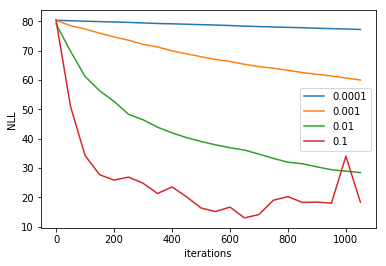

In [10]:
k=[0.0001,0.001,0.01,0.1]
for i in k:
    lr = LogReg(train_set, test_set, lam=0, eta=i)
    lr.train(num_epochs=1,report_step=50)
    l=range(0,len(lr.test_nll)*50,50)
    plt.plot(l,lr.test_nll)
plt.xlabel("iterations")
plt.ylabel("NLL")
plt.legend(k)

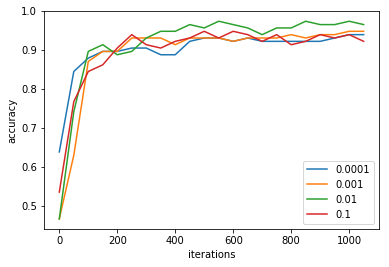

In [11]:
k=[0.0001,0.001,0.01,0.1]
for i in k:
    lr = LogReg(train_set, test_set, lam=0, eta=i)
    lr.train(report_step=50)
    l=range(0,len(lr.test_acc)*50,50)
    plt.plot(l,lr.test_acc)
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend(k)

As we can see that the value of nll is the lowest when eta is 0.1 but the graph for nll is not smooth that means that the model is not converging and hence the sudden increases and decreases in nll. But for eta = 0.01 the graph is converging pretty well and hence that is a good learning rate As we can see the accuarcy is almost the same for 0.1 and 0.001.

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [12]:
lr = LogReg(train_set, test_set, lam=0, eta=0.01)
lr.train(num_epochs=5)

In [13]:
i=zip(vocab[1:], lr.w[1:])
all_predictors=sorted(i, key=lambda x: x[1])
print("Top 10 automobile predictors")
print(*all_predictors[:10],sep="\n")
print("Top 10 motorcycle predictors")
print(*all_predictors[len(all_predictors)-10:][::-1],sep="\n")

Top 10 automobile predictors
('car', -1.0905219484523287)
('cars', -0.72976410851319051)
('ford', -0.32137722125640483)
('toyota', -0.29008936326821222)
('warning', -0.26905815784336123)
('dealer', -0.25527291200887015)
('engine', -0.25389890565092166)
('usa', -0.25141375617931466)
('eliot', -0.25013517396984181)
('oil', -0.24308076433985537)
Top 10 motorcycle predictors
('bike', 1.2681481356990889)
('dod', 1.1686875719027008)
('bikes', 0.61221784163448079)
('ride', 0.53795521588226791)
('riding', 0.50934354806566062)
('rider', 0.38749463826950414)
('helmet', 0.36130619303690714)
('jonathan', 0.30604031173519197)
('ca', 0.30144198887091211)
('shaft', 0.28989020507008989)


As we have found earlier that label 1 corresponds with motorcycles and 0 are automobiles. So features with big positive weights will be the best predictors for motorcycles and features with big negative weights are good predictors for automobiles. The code sorts the features by weights and prints the first 10 and last 10 for automobiles and motorcycles respectively

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [14]:

predictors=sorted(all_predictors,key=lambda x:abs(x[1]))
print("Worst predictors")
print(*predictors[:10],sep="\n")

Worst predictors
('paying', -1.4467700101307435e-07)
('goodyear', -7.4466533567393909e-07)
('rings', 1.4485848346809313e-06)
('sounding', -1.4694169542773442e-06)
('obey', -3.0725354680100443e-06)
('heavily', 3.8437054630482361e-06)
('lousy', 7.0175035571339289e-06)
('limited', -1.4621289921579673e-05)
('3rd', -1.542595306902675e-05)
('semiconductor', 1.6705229007200027e-05)


The values closest to 0 will be neither a good precitor for bikes or for cars and hence they are not useful. To find the worst predictors of both the classes we just sort it by the absolute values and print the first 1 values